In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from dataclasses import asdict
import math
import random
import itertools

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from minitorch.module import LinearScalarLayer, LinearTensorLayer, ScalarNetwork, TensorNetwork
from minitorch.autodiff import Scalar
import minitorch.autodiff.tensor_functions as tf
from minitorch.optim import SGDOptimizer
from minitorch.datasets import Datasets, DatasetTypes
from minitorch.operators import sigmoid
import minitorch.scalar_metrics as sm
import minitorch.scalar_losses as sl

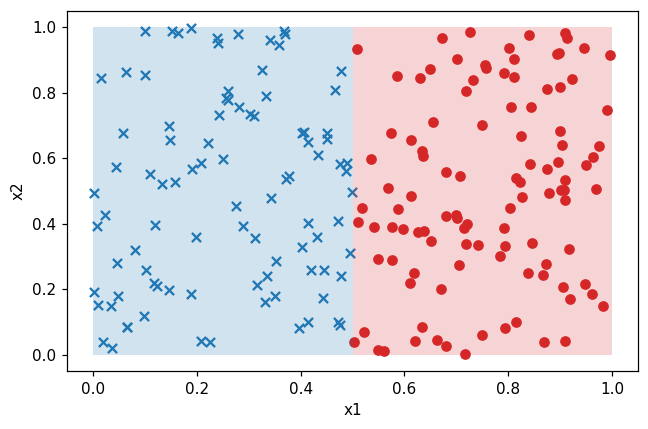

In [3]:
# Create a dataset
dataset_type = DatasetTypes.simple

datasets = Datasets.generate_datasets(n_samples=200)
dataset = asdict(datasets)[dataset_type]

pos_class = [x for (x, y) in zip(dataset.xs, dataset.ys) if y == 1]
neg_class = [x for (x, y) in zip(dataset.xs, dataset.ys) if y == 0]

x1_pos, x2_pos = zip(*pos_class)
x1_neg, x2_neg = zip(*neg_class)

fig, ax = plt.subplots(1, 1, dpi=110)
ax.scatter(list(x1_pos), list(x2_pos), marker="x", c="tab:blue")
ax.scatter(list(x1_neg), list(x2_neg), marker="o", c="tab:red")

left = Rectangle((0, 0), 0.5, 1.0, color="tab:blue", alpha=0.2, lw=0.0)
right = Rectangle((0.5, 0), 0.5, 1.0, color="tab:red", alpha=0.2, lw=0.0)
ax.add_patch(left)
ax.add_patch(right)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

fig.tight_layout();

### Scalars

In [4]:
# Create a linear network
linear = LinearScalarLayer(input_dim=2, output_dim=1)

In [5]:
# Define an optimizer
optimizer = SGDOptimizer(parameters=linear.parameters(), lr=0.75)

In [6]:
# Data
X = [list(x) for x in dataset.xs]
y_true = dataset.ys

In [7]:
# Training loop
n_epochs = 200
losses = []

for epoch in range(n_epochs): 
    
    # Zero all grads
    optimizer.zero_grad()
    
    # Forward
    y_hat = linear.forward(X)

    # Convert to binary class probabilties
    y_hat = [[scalar.sigmoid() for scalar in row] for row in y_hat]
    y_hat = list(itertools.chain.from_iterable(y_hat))

    # Compute a loss
    loss_per_epoch = sl.binary_cross_entropy(y_true, y_hat)
    loss_per_epoch.backward()
    
    optimizer.step()
    
    # Record
    losses.append(loss_per_epoch.data)
    if epoch % 10 == 0:
        print(f"epoch {epoch}: loss = {loss_per_epoch.data}")

epoch 0: loss = 0.578813107575419
epoch 10: loss = 0.5146110123442732
epoch 20: loss = 0.46775032983798676
epoch 30: loss = 0.4302287897045026
epoch 40: loss = 0.3996767499122002
epoch 50: loss = 0.3743973085210134
epoch 60: loss = 0.35316802364708305
epoch 70: loss = 0.3350991637388009
epoch 80: loss = 0.3195343361416823
epoch 90: loss = 0.30598211628916355
epoch 100: loss = 0.2940691077345281
epoch 110: loss = 0.28350751340732666
epoch 120: loss = 0.27407249560404606
epoch 130: loss = 0.26558617111216276
epoch 140: loss = 0.25790614583076504
epoch 150: loss = 0.25091719109085747
epoch 160: loss = 0.24452512159812423
epoch 170: loss = 0.2386522360043474
epoch 180: loss = 0.23323388063609826
epoch 190: loss = 0.22821583043619112


In [8]:
# Metrics
y_true = [Scalar(y_t) for y_t in y_true]
y_hat = [[scalar.sigmoid() for scalar in row] for row in linear.forward(X)]
y_hat = list(itertools.chain.from_iterable(y_hat))

# Convert to classes using 0.5 threshold
y_hat_classes = [Scalar(1.0) if proba.data >= 0.5 else Scalar(0.0) for proba in y_hat]

{
    f.__name__: f(y_true=y_true, y_hat=y_hat_classes)
    for f in [sm.accuracy, sm.precision, sm.recall]
}

{'accuracy': Scalar(0.970, name=Scalar366605),
 'precision': Scalar(0.989, name=Scalar367596),
 'recall': Scalar(0.946, name=Scalar368587)}

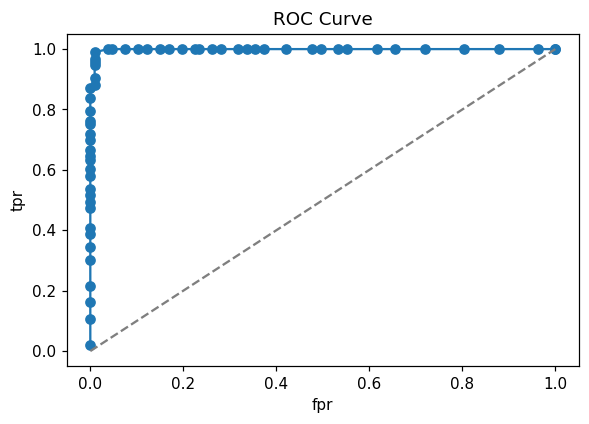

In [9]:
# ROC Curve
tpr, fpr, thresholds = sm.roc_curve(y_true, y_hat, bucket_size=0.01)
tpr, fpr = [s.data for s in tpr], [s.data for s in fpr]

fig, ax = plt.subplots(1, 1, dpi=110)
ax.plot(fpr, tpr, "-o", c="tab:blue")
ax.plot([0, 1], [0, 1], ls="--", c="tab:grey")
ax.set_xlabel("fpr")
ax.set_ylabel("tpr")
ax.set_title("ROC Curve");

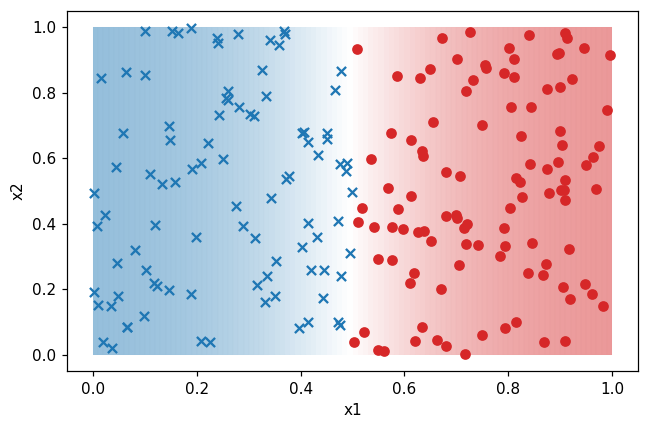

In [10]:
# Visualising predictions
fig, ax = plt.subplots(1, 1, dpi=110)
ax.scatter(list(x1_pos), list(x2_pos), marker="x", c="tab:blue")
ax.scatter(list(x1_neg), list(x2_neg), marker="o", c="tab:red")

# Visualise classification function

x1_positions = list(np.linspace(0, 1, 101))

for x1_lower, x1_upper in zip(x1_positions, x1_positions[1:]):
    
    # Create corresponding x2 values for lower
    X_lower = [list((x1_lower, i/10)) for i in range(11)]
    y_lower = linear.forward(X_lower)
    y_mean_lower = sigmoid(sum(scalar[0].data for scalar in y_lower) / len(y_lower))

    # Create corresponding x2 values for upper
    X_upper = [list((x1_upper, i/10)) for i in range(11)]
    y_upper = linear.forward(X_upper)
    y_mean_upper = sigmoid(sum(scalar[0].data for scalar in y_upper) / len(y_upper))

    # Plot and fill    
    ax.fill_betweenx(
        [i/10 for i in range(11)],
        [x1_upper for _ in range(11)],
        x1_lower,
        alpha=(y_mean_lower - 0.5) if y_mean_lower >= 0.5 else (0.5 - y_mean_lower),
        color="tab:blue" if y_mean_lower >= 0.5 else "tab:red",
        lw=0.01
    )

ax.set_xlabel("x1")
ax.set_ylabel("x2")

fig.tight_layout();

### Tensors

In [11]:
# Create a linear layer
linear = LinearTensorLayer(input_dim=2, output_dim=1)

In [18]:
# Define an optimizer
optimizer = SGDOptimizer(parameters=linear.parameters(), lr=0.75)

In [24]:
# Data
X = tf.tensor([list(x) for x in dataset.xs])
y_true = dataset.ys

In [17]:
# Training loop
n_epochs = 200
losses = []

for epoch in range(n_epochs): 
    
    # Zero all grads
    optimizer.zero_grad()
    
    # Forward
    y_hat = linear.forward(X)

    # Convert to binary class probabilties
    y_hat = [[scalar.sigmoid() for scalar in row] for row in y_hat]
    y_hat = list(itertools.chain.from_iterable(y_hat))

    # Compute a loss
    loss_per_epoch = binary_cross_entropy(y_true, y_hat)
    loss_per_epoch.backward()
    
    optimizer.step()
    
    # Record
    losses.append(loss_per_epoch.data)
    if epoch % 10 == 0:
        print(f"epoch {epoch}: loss = {loss_per_epoch.data}")

minitorch.autodiff.tensor.Tensor